# Sign Game Server

Game Plan:

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import string
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb



## Dataset Preprocessing

In [2]:
# Dataset
df_train = pd.read_csv('/Users/calebgarfinkel/Documents/Study/Le Wagon/Project/data/train.csv')
df_test = pd.read_csv('/Users/calebgarfinkel/Documents/Study/Le Wagon/Project/data/test.csv')

In [7]:
df_test.columns

Index(['WRIST_X', 'WRIST_Y', 'WRIST_Z', 'THUMB_CMC_X', 'THUMB_CMC_Y',
       'THUMB_CMC_Z', 'THUMB_MCP_X', 'THUMB_MCP_Y', 'THUMB_MCP_Z',
       'THUMB_IP_X', 'THUMB_IP_Y', 'THUMB_IP_Z', 'THUMB_TIP_X', 'THUMB_TIP_Y',
       'THUMB_TIP_Z', 'INDEX_FINGER_MCP_X', 'INDEX_FINGER_MCP_Y',
       'INDEX_FINGER_MCP_Z', 'INDEX_FINGER_PIP_X', 'INDEX_FINGER_PIP_Y',
       'INDEX_FINGER_PIP_Z', 'INDEX_FINGER_DIP_X', 'INDEX_FINGER_DIP_Y',
       'INDEX_FINGER_DIP_Z', 'INDEX_FINGER_TIP_X', 'INDEX_FINGER_TIP_Y',
       'INDEX_FINGER_TIP_Z', 'MIDDLE_FINGER_MCP_X', 'MIDDLE_FINGER_MCP_Y',
       'MIDDLE_FINGER_MCP_Z', 'MIDDLE_FINGER_PIP_X', 'MIDDLE_FINGER_PIP_Y',
       'MIDDLE_FINGER_PIP_Z', 'MIDDLE_FINGER_DIP_X', 'MIDDLE_FINGER_DIP_Y',
       'MIDDLE_FINGER_DIP_Z', 'MIDDLE_FINGER_TIP_X', 'MIDDLE_FINGER_TIP_Y',
       'MIDDLE_FINGER_TIP_Z', 'RING_FINGER_MCP_X', 'RING_FINGER_MCP_Y',
       'RING_FINGER_MCP_Z', 'RING_FINGER_PIP_X', 'RING_FINGER_PIP_Y',
       'RING_FINGER_PIP_Z', 'RING_FINGER_DIP_X', 'RING

In [4]:
# Drop unwanted columns in train/test sets
df_test = df_test.drop(columns=df_test.columns[[0, -1]], axis=1)
df_train = df_train.drop(columns=df_train.columns[[0, -1]], axis=1)

In [5]:
# Drop NA values, reset index
df_train = df_train.dropna().reset_index(drop=True)
df_test = df_test.dropna().reset_index(drop=True)

In [6]:
X_train, y_train = df_train.drop("TARGET", axis=1), df_train[['TARGET']]
X_test, y_test = df_test.drop("TARGET", axis=1), df_test[['TARGET']]

In [8]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size = 0.5, random_state = 42)

In [9]:
y_test.shape

(21650, 1)

In [10]:
# Encode y to numeric
oe = OrdinalEncoder()
oe.fit(y_train.values.reshape(-1,1))
y_train_enc = oe.transform(y_train.values.reshape(-1,1))
y_val_enc = oe.transform(y_val.values.reshape(-1,1))
y_test_enc = oe.transform(y_test.values.reshape(-1,1))

In [36]:
params = {
    "max_depth": 10,
    "learning_rate": 0.01,
    "gamma" : 1,
    "objective": "multi:softprob", 
    "tree_method": "hist", 
    "num_class": 26
}


dtrain_clf = xgb.DMatrix(X_train, label=y_train_enc)
dval_clf = xgb.DMatrix(X_val, label=y_val_enc)

evallist = [(dval_clf, 'eval'), (dtrain_clf, 'train')]

num_rounds = 10000

model = xgb.train(params = params, 
                  dtrain = dtrain_clf, 
                  num_boost_round = num_rounds, 
                  evals = evallist,
                  verbose_eval = 50,
                  early_stopping_rounds = 50
                 )


[0]	eval-mlogloss:3.15856	train-mlogloss:3.15520
[50]	eval-mlogloss:1.51168	train-mlogloss:1.43755
[100]	eval-mlogloss:0.98615	train-mlogloss:0.88754
[150]	eval-mlogloss:0.69785	train-mlogloss:0.58742
[200]	eval-mlogloss:0.52169	train-mlogloss:0.40410
[250]	eval-mlogloss:0.40809	train-mlogloss:0.28657
[300]	eval-mlogloss:0.33188	train-mlogloss:0.20883
[350]	eval-mlogloss:0.27959	train-mlogloss:0.15649
[400]	eval-mlogloss:0.24334	train-mlogloss:0.12117
[450]	eval-mlogloss:0.21777	train-mlogloss:0.09653
[500]	eval-mlogloss:0.19899	train-mlogloss:0.07900
[550]	eval-mlogloss:0.18485	train-mlogloss:0.06615
[600]	eval-mlogloss:0.17409	train-mlogloss:0.05665
[650]	eval-mlogloss:0.16575	train-mlogloss:0.04954
[700]	eval-mlogloss:0.15924	train-mlogloss:0.04418
[750]	eval-mlogloss:0.15413	train-mlogloss:0.03999
[800]	eval-mlogloss:0.14996	train-mlogloss:0.03679
[850]	eval-mlogloss:0.14655	train-mlogloss:0.03424
[900]	eval-mlogloss:0.14380	train-mlogloss:0.03227
[950]	eval-mlogloss:0.14200	train-

In [37]:
dtest = xgb.DMatrix(X_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 0.00%


In [34]:
y_test, y_pred

(      TARGET
 34430      Z
 8056       P
 23876      P
 27895      H
 16641      I
 ...      ...
 6265       K
 11284      B
 38158      O
 860        N
 15795      R
 
 [21650 rows x 1 columns],
 array([25, 15, 15, ..., 14, 13, 17]))

<function matplotlib.pyplot.show(close=None, block=None)>

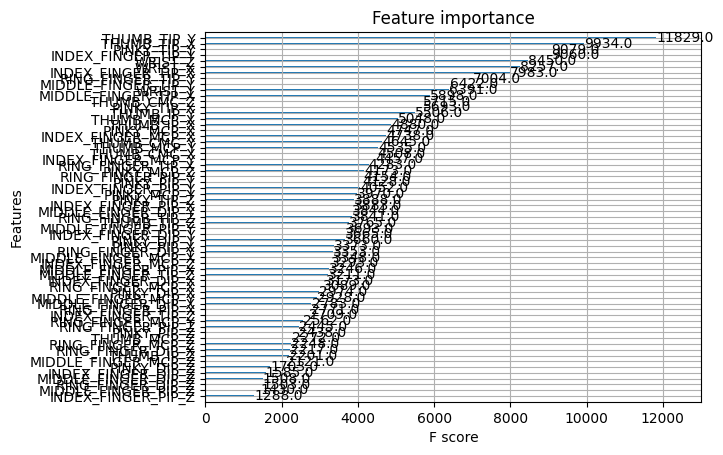

In [35]:
xgb.plot_importance(model)
plt.show

## KNN Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train_encoded)

## Predict

In [ ]:
y_preds = knn.predict(X_test_scaled)
y_preds

In [ ]:
letter_preds = [y_train_dic[y_pred] for y_pred in y_preds]
letter_preds

In [ ]:
def evaluate_model(y_test, y_pred):
#     # Preditions on holdout test dataset
#     y_pred = model.predict(X_test)
#     y_pred = np.argmax(y_pred, axis=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=range(26), columns=range(26))
    plt.figure(figsize=(10, 8))
    plt.title('Model Confusion Matrix')
    plt.xlabel('Predicted Letter')
    plt.ylabel('True Letter')
    plt.xticks(range(26), labels=range(26))
    plt.yticks(range(26), labels=range(26))
    plt.imshow(cm_df)
    plt.colorbar()
    plt.show()
    
    # Calculate classification report
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    print('Accuracy:', accuracy)

In [ ]:
evaluate_matrix(y_test, letter_preds)

In [ ]:
evaluate_model(letter_preds, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

params={'n_neighbors': [num for num in range(1, 15)]}
search_accuracy = GridSearchCV(KNeighborsClassifier(),
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
search_accuracy.fit(X_train_scaled, y_train_encoded)
search_accuracy.best_params_

In [ ]:
params={'n_neighbors': [num for num in range(1, 15)]}
search2_accuracy = GridSearchCV(KNeighborsClassifier(),
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
search2_accuracy.fit(X_train, y_train_encoded)
search2_accuracy.best_params_

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(X_train, y_train_encoded)

In [ ]:
y_preds2 = knn2.predict(X_test)
y_preds2

In [ ]:
letter_preds2 = [y_train_dic[y_pred2] for y_pred2 in y_preds2]
letter_preds2

In [ ]:
evaluate_matrix(y_test, letter_preds2)

In [ ]:
evaluate_model(letter_preds2, y_test)